In [1]:
def imshow(img):
    img = img.to("cpu")
    img = torchvision.utils.make_grid(img)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
def showImgSketchAtIndex(dataset,index):
    data = dataset[index]
    print(f"Path: {data[2]}")
    imshow(data[0])
    print(f"Path: {data[3]}")
    imshow(data[1])
    print(f"Label: {data[4]}")
    print("---------------------------------------")

def show_pairs(dataset, start, stop):
    for i in range (start, stop):
        showImgSketchAtIndex(dataset,i)

#Checkpoint of trained on trainset
#CHECKPOINT = "/nfs/home/korzybskia/BA/sketchy_ckpt/Transforms=-'jitter': False, 'erase': False, 'rotation': False, 'hflip': False, 'vflip': False-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.ckpt"

#Checkpoint of small overfit_trainset for trying to overfit
#CHECKPOINT = "/nfs/home/korzybskia/BA/output/epoch=199-step=400.ckpt"
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from train import *
from tqdm import tqdm
import pickle
from os.path import exists
from sklearn import metrics
from torch.utils.tensorboard import SummaryWriter

#model = SiameseModel.load_from_checkpoint(CHECKPOINT)
#model.eval()

def load_pickle(path):
    pickle_in = open(path,"rb")
    loaded_object= pickle.load(pickle_in)
    pickle_in.close()
    
    return loaded_object
    

# Run this after training is done to save all img feature vecs from training+test datasets, to be able to retrieve them later in testing.
# returns retrieval_imgs_db => [(img_feature_vec1, img1), (img_feature_vec2, img2),...]
#MIGHTVE A BUG SOMEWHERE

"""
def save_all_imgs_to_retrieval_db(post_tr_train_loader, post_tr_test_loader):
    with torch.no_grad():
        retrieval_imgs_db = []
        if post_tr_train_loader is not None:
            for batch in tqdm(post_tr_train_loader):
                images = batch[1]
                images_feature_vecs = model({"image": images})
                images_feature_vecs = images_feature_vecs["image"]
                zipped = tuple(zip(images_feature_vecs, images))
                for element in zipped:
                    retrieval_imgs_db.append(element)
                
        if post_tr_test_loader is not None:            
            for batch in tqdm(post_tr_test_loader):
                images = batch[1]
                images_feature_vecs = model({"image": images})
                images_feature_vecs = images_feature_vecs["image"]
                zipped = tuple(zip(images_feature_vecs, images))
                for element in zipped:
                    retrieval_imgs_db.append(element)

        assert torch.equal(images_feature_vecs[-2], retrieval_imgs_db[-2][0]) == True
        assert torch.equal(images[-1], retrieval_imgs_db[-1][1]) == True
        assert torch.equal(images_feature_vecs[-10], retrieval_imgs_db[-10][0]) == True

        return retrieval_imgs_db
 """   
"""
def save_all_imgs_to_retrieval_db(post_tr_train_loader, post_tr_test_loader):
    with torch.no_grad():
        retrieval_imgs_db = []
        if post_tr_train_loader is not None:
            for batch in tqdm(post_tr_train_loader):
                images = batch[1]
                images_paths = batch[3]
                images_feature_vecs = model({"image": images})
                images_feature_vecs = images_feature_vecs["image"]
                zipped = tuple(zip(images_feature_vecs, images_paths))
                for element in zipped:
                    retrieval_imgs_db.append(element)
                
        if post_tr_test_loader is not None:            
            for batch in tqdm(post_tr_test_loader):
                images = batch[1]
                images_paths = batch[3]
                images_feature_vecs = model({"image": images})
                images_feature_vecs = images_feature_vecs["image"]
                zipped = tuple(zip(images_feature_vecs, images_paths))
                for element in zipped:
                    retrieval_imgs_db.append(element)

        assert torch.equal(images_feature_vecs[-2], retrieval_imgs_db[-2][0]) == True
        assert (images_paths[-1] == retrieval_imgs_db[-1][1]) == True
        assert torch.equal(images_feature_vecs[-10], retrieval_imgs_db[-10][0]) == True

        return retrieval_imgs_db
"""
# Only needs to run if model has been updated i.e. new CHECKPOINT exists
# returns retrieval_imgs_dict i.e.  => ["features"] =>type:list of tensors, shape (#imgs,256); ["paths"] => type:list of strings,shape (#imgs,1)
def save_all_imgs_to_retrieval_db(model, checkpoint, post_tr_train_loader, post_tr_test_loader, overwrite_pickle=False):
    #TODO CHANGE PICKLE_NAMING
    pickle_name = checkpoint
    pickle_name = pickle_name.replace('/', '_')
    pickle_name = pickle_name.replace('.ckpt', '.pickle')
    pickle_name = "retrieval_imgs_dicts/retrieval_imgs_dict"+pickle_name
    
    if (exists(pickle_name) == False) or (overwrite_pickle==True):
        with torch.no_grad():
            all_image_feature_vecs = []
            all_image_paths = []
            all_labels = []
            if post_tr_train_loader is not None:
                for batch in tqdm(post_tr_train_loader):
                    images = batch[1]
                    images = images.to("cuda")
                    images_paths = batch[3]
                    labels = batch[4]
                    images_feature_vecs = model({"image": images})
                    images_feature_vecs = images_feature_vecs["image"]
                    images_feature_vecs = images_feature_vecs.to("cuda")
                    for image_feature_vec in images_feature_vecs:
                        all_image_feature_vecs.append(image_feature_vec)
                    for image_path in images_paths:
                        all_image_paths.append(image_path)
                    for label in labels:
                        all_labels.append(label)

            if post_tr_test_loader is not None:            
                for batch in tqdm(post_tr_test_loader):
                    images = batch[1]
                    images = images.to("cuda")
                    images_paths = batch[3]
                    labels = batch[4]
                    images_feature_vecs = model({"image": images})
                    images_feature_vecs = images_feature_vecs["image"]
                    images_feature_vecs = images_feature_vecs.to("cuda")
                    for image_feature_vec in images_feature_vecs:
                        all_image_feature_vecs.append(image_feature_vec)
                    for image_path in images_paths:
                        all_image_paths.append(image_path)
                    for label in labels:
                        all_labels.append(label)

            retrieval_imgs_dict = {"features":all_image_feature_vecs, "paths":all_image_paths, "labels":all_labels}

            assert torch.equal(images_feature_vecs[-2], retrieval_imgs_dict["features"][-2]) == True
            assert (images_paths[-1] == retrieval_imgs_dict["paths"][-1]) == True
            assert torch.equal(images_feature_vecs[-10], retrieval_imgs_dict["features"][-10]) == True

            print("Writing dict to pickle...")
            pickle_out = open(pickle_name,"wb")
            pickle.dump(retrieval_imgs_dict,pickle_out)
            pickle_out.close()
            print("Done writing pickle...")
            print("Returning imgs_db directly!")
            return retrieval_imgs_dict
    else:
        print("Skipping saving dict to pickle!")
        print("Loading pickle! "+pickle_name)
        return load_pickle(pickle_name)

        

#goes over whole batch
#returns most similar images ranked list to corresponding sketches (n=batch size) list: [most_similar_imgs_list_to_sketch#1, most_similar_imgs_list_to_sketch#2, ... most_similar_imgs_list_to_sketch#n]
#TODO not sure if working as expected
"""
def retrieve_imgs(sketch_feature_vecs, images_db):
    list_of_images = []
    for sketch_feature_vec in sketch_feature_vecs:
        max_similarity = 0
        images = []
        for img_feature_vec, image in images_db:
            cos = nn.CosineSimilarity(dim=0)
            similarity = cos(sketch_feature_vec, img_feature_vec)
            if similarity > max_similarity:
                max_similarity = similarity
                max_image = image
                images.append(max_image)
                #print(max_similarity)
        images.reverse()
        list_of_images.append(images)        
    return list_of_images   
"""
"""
def retrieve_imgs(sketch_feature_vecs, images_db):
    list_of_images = []
    img_features = images_db["features"]
    img_paths = images_db["paths"]
    for sketch_feature_vec in sketch_feature_vecs:
        max_similarity = 0
        images = []
        for index, img_feature in enumerate(img_features):
            cos = nn.CosineSimilarity(dim=0)
            similarity = cos(sketch_feature_vec, img_feature)
            if similarity > max_similarity:
                max_similarity = similarity
                img_index = index
                max_path = img_paths[index]
                max_image = load_img_from_path(max_path, val_loader)
                images.append(max_image)
                #print(max_similarity)
        images.reverse()
        list_of_images.append(images)        
    return list_of_images   
"""
"""
sketch features shape->(64,256)

retrieve_imgs(sketch_vecs,topk=2):
returns:
                 sketch1     ,...,  sketch4
result_imgs = [img1,img2],  [...], [img1,img2]

"""
def retrieve_imgs(sketch_features, images_db, top_k=3):
    list_of_images_lists = []
    #img_features shape => (12500,256)
    img_features = images_db["features"]
    img_features = torch.stack(img_features)
    #img_paths shape => (12500)
    img_paths = images_db["paths"]
    #cosinesim_matrix shape => (64,12500)
    cosinesim_matrix=metrics.pairwise.cosine_similarity(sketch_features, img_features)
    cosinesim_matrix = torch.tensor(cosinesim_matrix)
    #Find right indices for highest sim_scores for each sketch, top k results
    scores, indices = torch.topk(cosinesim_matrix, k=top_k)
    
    sketch_i = 0
    while sketch_i<sketch_features.shape[0]:
        sketch_i_results = []
        #append top-k images for sketch_i
        for i in indices[sketch_i]:
            path = img_paths[i]
            img = load_img_from_path(path,val_loader)
            sketch_i_results.append(img)
        list_of_images_lists.append(sketch_i_results)
        sketch_i += 1
    
    
    assert torch.equal(img_features[2],images_db["features"][2])==True
    
    
    return list_of_images_lists

def retrieve_imgs_paths(sketch_features, images_db, top_k=3):
    list_of_images_paths_labels = []
    #img_features shape => (12500,256)
    img_features = images_db["features"]
    img_features = torch.stack(img_features)
    img_features = img_features.to("cuda")
    #img_paths shape => (12500)
    img_paths = images_db["paths"]
    img_labels = images_db["labels"]
    #cosinesim_matrix shape => (64,12500)
    cosinesim_matrix=metrics.pairwise.cosine_similarity(sketch_features.to("cpu"), img_features.to("cpu"))
    cosinesim_matrix = torch.tensor(cosinesim_matrix)
    #Find right indices for highest sim_scores for each sketch, top k results
    scores, indices = torch.topk(cosinesim_matrix, k=top_k)
    
    sketch_i = 0
    while sketch_i<sketch_features.shape[0]:
        sketch_i_results = []
        #append top-k images for sketch_i
        for i in indices[sketch_i]:
            path = img_paths[i]
            img_label = img_labels[i]
            sketch_i_results.append((path,img_label))
        list_of_images_paths_labels.append(sketch_i_results)
        sketch_i += 1
    
    
    #assert torch.equal(img_features[2],images_db["features"][2])==True
    
    
    return list_of_images_paths_labels
    
#runs over data_loader and calculates how many images are found correctly in the imgs_db given input sketch
#output=True for additional prints

def calc_model_accuracy(data_loader, imgs_db, output=False, top_k=3):
    with torch.no_grad():
        hits = 0
        images_amount = len(data_loader.dataset)
        for data in tqdm(data_loader):
            sketches = data[0]
            images = data[1]
            sketch_vecs = model({"sketch":sketches})
            sketch_vecs = sketch_vecs["sketch"]
            result_imgs = retrieve_imgs(sketch_vecs, imgs_db, top_k)
            
            for sketch_i, results_at_i in enumerate(result_imgs):
                for rank,result in enumerate(results_at_i,1):
                    if torch.equal(images[sketch_i], result) == True:
                        hits += 1
                        if output == True:
                            print("Hit! at rank ",rank)
                            print("Hit_Input_Sketch")
                            imshow(sketches[sketch_i])
                            print("Hit_Input_Image")
                            imshow(images[sketch_i])
                            print("Hit_Result_Image")
                            imshow(result)
                        break
                        
        accuracy = hits/images_amount     
        print("Total hits ",hits)  
        print("Accuracy: ",accuracy)
        
def calc_model_accuracy_with_paths_and_labels(model, data_loader, imgs_db, output=False, top_k=3):
    with torch.no_grad():
        print("Starting calc_model_accuracy_with_paths_and_labels")
        hits_paths = 0
        hits_labels = 0
        images_amount = len(data_loader.dataset)
        for data in tqdm(data_loader):
            if output == True:
                images = data[1]
                images = images.to("cuda")
            sketches = data[0]
            sketches = sketches.to("cuda")
            images_paths = data[3]
            labels = data[4]
            sketch_vecs = model({"sketch":sketches})
            sketch_vecs = sketch_vecs["sketch"]
            sketch_vecs = sketch_vecs.to("cuda")
            result_imgs_paths = retrieve_imgs_paths(sketch_vecs, imgs_db, top_k)
            
            for sketch_i, results_at_i in enumerate(result_imgs_paths):
                label_hit = False
                for rank,result in enumerate(results_at_i,1):
                    result_path,result_label = result
                    if images_paths[sketch_i] == result_path:
                        hits_paths += 1
                        if label_hit == False:
                            hits_labels += 1
                        if output == True:
                            print("Hit! at rank ",rank)
                            print("Hit_Input_Sketch")
                            imshow(sketches[sketch_i])
                            print("Hit_Input_Image")
                            imshow(images[sketch_i])
                            print("Hit_Result_Image")
                            result_img = load_img_from_path(result_path,val_loader)
                            imshow(result_img)
                        break
                    elif (label_hit == False) and (labels[sketch_i] == result_label):
                        hits_labels += 1
                        label_hit = True
                        if output == True:
                            print("Hit! at rank ",rank)
                            print("Hit_Input_Sketch")
                            imshow(sketches[sketch_i])
                            print("Hit_Input_Image")
                            imshow(images[sketch_i])
                            print("Hit_Result_Image")
                            result_img = load_img_from_path(result_path,val_loader)
                            imshow(result_img)
                        
        accuracy_paths = hits_paths/images_amount
        print(f"Top {top_k}")
        print("Total hits_paths ",hits_paths)  
        print("Accuracy paths: ",accuracy_paths)
        
        accuracy_labels = hits_labels/images_amount
        print(f"Top {top_k}")
        print("Total hits_labels ",hits_labels)  
        print("Accuracy paths: ",accuracy_labels)
        return accuracy_paths, accuracy_labels
    
def calc_model_accuracy_with_paths(model, data_loader, imgs_db, output=False, top_k=3):
    with torch.no_grad():
        print("Starting calc_model_accuracy_with_paths")
        hits = 0
        images_amount = len(data_loader.dataset)
        for data in tqdm(data_loader):
            if output == True:
                images = data[1]
            sketches = data[0]
            images_paths = data[3]
            sketch_vecs = model({"sketch":sketches})
            sketch_vecs = sketch_vecs["sketch"]
            result_imgs_paths = retrieve_imgs_paths(sketch_vecs, imgs_db, top_k)
            
            for sketch_i, results_at_i in enumerate(result_imgs_paths):
                for rank,result in enumerate(results_at_i,1):
                    result_path,result_label = result
                    if images_paths[sketch_i] == result_path:
                        hits += 1
                        if output == True:
                            print("Hit! at rank ",rank)
                            print("Hit_Input_Sketch")
                            imshow(sketches[sketch_i])
                            print("Hit_Input_Image")
                            imshow(images[sketch_i])
                            print("Hit_Result_Image")
                            result_img = load_img_from_path(result_path,val_loader)
                            imshow(result_img)
                        break
                        
        accuracy = hits/images_amount
        print(f"Top {top_k}")
        print("Total hits ",hits)  
        print("Accuracy: ",accuracy)
        return accuracy
    
def calc_model_accuracy_with_labels(model, data_loader, imgs_db, output=False, top_k=3):
    with torch.no_grad():
        print("Starting calc_model_accuracy_with_labels")
        hits = 0
        images_amount = len(data_loader.dataset)
        for data in tqdm(data_loader):
            if output == True:
                images = data[1]
                images = images.to("cuda")
            sketches = data[0]
            sketches = sketches.to("cuda")
            images_paths = data[3]
            labels = data[4]
            sketch_vecs = model({"sketch":sketches})
            sketch_vecs = sketch_vecs["sketch"]
            sketch_vecs = sketch_vecs.to("cuda")
            result_imgs_paths = retrieve_imgs_paths(sketch_vecs, imgs_db, top_k)
            
            for sketch_i, results_at_i in enumerate(result_imgs_paths):
                for rank,result in enumerate(results_at_i,1):
                    result_path,result_label = result
                    if labels[sketch_i] == result_label:
                        hits += 1
                        if output == True:
                            print("Hit! at rank ",rank)
                            print("Hit_Input_Sketch")
                            imshow(sketches[sketch_i])
                            print("Hit_Input_Image")
                            imshow(images[sketch_i])
                            print("Hit_Result_Image")
                            result_img = load_img_from_path(result_path,val_loader)
                            imshow(result_img)
                        break
                        
        accuracy = hits/images_amount
        print(f"Top {top_k}")
        print("Total hits ",hits)  
        print("Accuracy: ",accuracy)
        return accuracy
    
def calc_acc_and_log(model,checkpoint,data_loader, imgs_db, max_k=11):
    log_comment = checkpoint
    log_comment = log_comment.replace('/', '_')
    log_comment = log_comment.replace('.ckpt', '-ckpt')
    log_comment = log_comment+"-accuracies"
    
    writer = SummaryWriter(comment=log_comment)
    for i in range(2,max_k,2):
        accuracy_paths, accuracy_labels = calc_model_accuracy_with_paths_and_labels(model, data_loader, imgs_db, output=False, top_k=i)
        #accuracy = calc_model_accuracy_with_paths(model, data_loader, imgs_db, output=False, top_k=i)
        writer.add_scalar('(exact match)accuracy/top-k', accuracy_paths, i)
        #accuracy = calc_model_accuracy_with_labels(model, data_loader, imgs_db, output=False, top_k=i)
        writer.add_scalar('(match by label)accuracy/top-k', accuracy_labels, i)
    writer.close()
        
        
#Predicts results of model for <amount> randomly chosen input sketches, used to test performance anecdotally 
def predict(dataloader, amount, top_k=3):
    with torch.no_grad():
        for data in dataloader:
            sketches = data[0]
            sketches = sketches[:amount]
            images = data[1]
            images = images[:amount]
            sketch_vecs = model({"sketch":sketches})
            sketch_vecs = sketch_vecs["sketch"]
            result_imgs = retrieve_imgs(sketch_vecs, imgs_db, top_k)
            for sketchnr, result in enumerate(result_imgs):
                print("Input Sketch#", sketchnr)
                imshow(sketches[sketchnr])
                print("Actual correct Image")
                imshow(images[sketchnr])
                print("Results for Sketch#",sketchnr)
                result = torch.stack(result)
                #Show top 5 results per input sketch
                imshow(result)               
            break

#Used during testing
def load_img_from_path(path, dataloader):
    img = dataloader.dataset.loader(path)
    img = dataloader.dataset.transform(img)
    return img

    
def run(checkpoint):
    model = SiameseModel.load_from_checkpoint(checkpoint)
    model = model.to("cuda")
    model.eval()
    #model.to("cuda")
    
    post_tr_train_set = ImgSketchDataset(root, transform_norandoms, transform_norandoms, train=True, trainsplit_decimal=0.9, rnd_aug=False)
    post_tr_train_loader = DataLoader(post_tr_train_set, BATCH_SIZE_TRAIN_LOADER, shuffle=True, num_workers=4)
    
    imgs_db = save_all_imgs_to_retrieval_db(model, checkpoint,post_tr_train_loader=post_tr_train_loader, post_tr_test_loader=val_loader, overwrite_pickle=False)
    print("imgs db len")
    print(len(imgs_db["paths"]))
    print(len(imgs_db["features"]))
    print(imgs_db["features"][10])
    print(imgs_db["paths"][10])
    calc_acc_and_log(model,checkpoint,data_loader=val_loader,imgs_db=imgs_db,max_k=11)
    

1
True
1.13.0
photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250
photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
1250
sketch
IMGS DIR
./Data/Sketchy/256x256_stylized/photo
SKETCHES DIR
./Data/Sketchy/256x256_stylized/sketch
22500
<bound method DatasetFolder.__len__ of Dataset ImgSketchDataset
    Number of datapoints: 22500
    Root location: ./Data/Sketchy/256x256_stylized
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Target transform: Compose(
                      Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                      ToTensor()
                      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  )>


Path: ./Data/Sketchy/256x256_stylized/sketch/cat/n02121620_3196-1.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


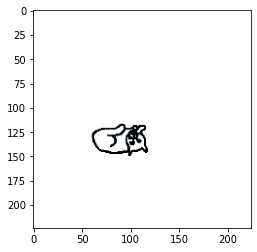

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path: ./Data/Sketchy/256x256_stylized/photo/cat/n02121620_3196_stylized_56647.jpg


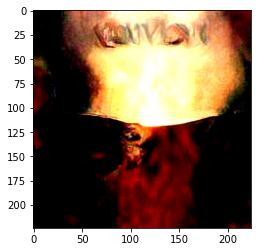

Label: cat
---------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path: ./Data/Sketchy/256x256_stylized/sketch/cat/n02121620_3196-1.png


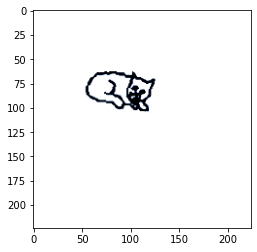

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path: ./Data/Sketchy/256x256_stylized/photo/cat/n02121620_3196_stylized_61544.jpg


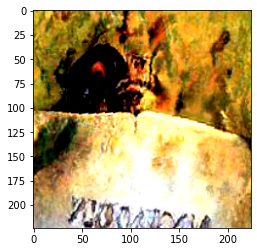

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cat
---------------------------------------
Path: ./Data/Sketchy/256x256_stylized/sketch/cat/n02121620_32013-1.png


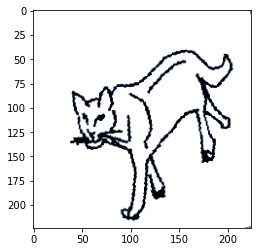

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path: ./Data/Sketchy/256x256_stylized/photo/cat/n02121620_32013_stylized_34715.jpg


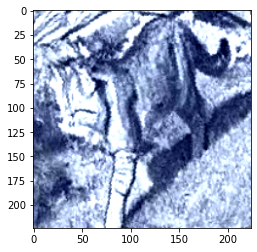

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cat
---------------------------------------
Path: ./Data/Sketchy/256x256_stylized/sketch/cat/n02121620_32013-1.png


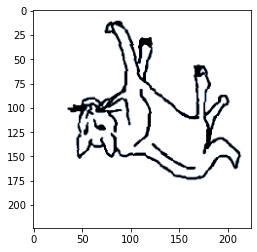

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path: ./Data/Sketchy/256x256_stylized/photo/cat/n02121620_32013_stylized_76914.jpg


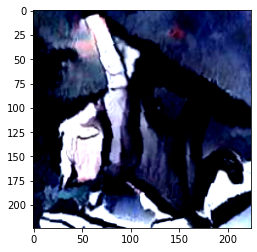

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cat
---------------------------------------
Path: ./Data/Sketchy/256x256_stylized/sketch/cat/n02121620_32053-1.png


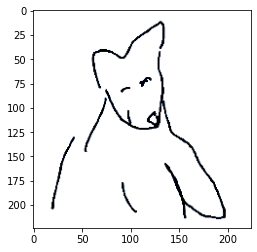

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path: ./Data/Sketchy/256x256_stylized/photo/cat/n02121620_32053_stylized_30447.jpg


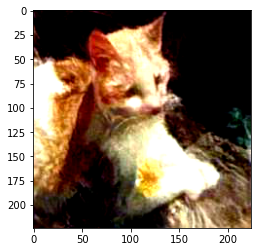

Label: cat
---------------------------------------


In [2]:
#show_pairs(train_set, 310,311)
#show_pairs(post_tr_train_set, 310,311)
show_pairs(train_set_stylized, 100,105)

In [5]:
print(train_set_stylized)

Dataset ImgSketchDataset
    Number of datapoints: 22500
    Root location: ./Data/Sketchy/256x256_stylized
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Target transform: Compose(
                      Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                      ToTensor()
                      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  )


In [3]:
post_tr_train_set = ImgSketchDataset(root, transform_norandoms, transform_norandoms, train=True, trainsplit_decimal=0.9, rnd_aug=False)
post_tr_train_loader = DataLoader(post_tr_train_set, BATCH_SIZE_TRAIN_LOADER, shuffle=True, num_workers=4)


In [4]:
#Needs to be called everytime model changes i.e. after loading a new model
#imgs_db = save_all_imgs_to_retrieval_db(post_tr_train_loader=post_tr_train_loader, post_tr_test_loader=val_loader)
imgs_db = save_all_imgs_to_retrieval_db(checkpoint, post_tr_train_loader=post_tr_train_loader, post_tr_test_loader=val_loader, overwrite_pickle=False)

NameError: name 'checkpoint' is not defined

In [78]:
calc_model_accuracy_with_paths(val_loader,imgs_db, output=False, top_k=2)

100%|██████████| 20/20 [01:13<00:00,  3.65s/it]

Total hits  39
Accuracy:  0.0312


In [5]:
calc_acc_and_log(data_loader=val_loader,imgs_db=imgs_db,max_k=11)

100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Total hits  11
Accuracy:  0.0088


100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Total hits  30
Accuracy:  0.024


100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Total hits  43
Accuracy:  0.0344


100%|██████████| 20/20 [01:13<00:00,  3.69s/it]


Total hits  57
Accuracy:  0.0456


100%|██████████| 20/20 [01:12<00:00,  3.65s/it]

Total hits  71
Accuracy:  0.0568


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Sketch# 0


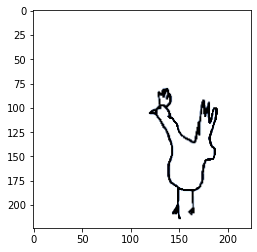

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual correct Image


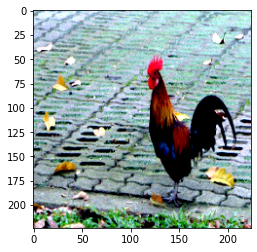

Results for Sketch# 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


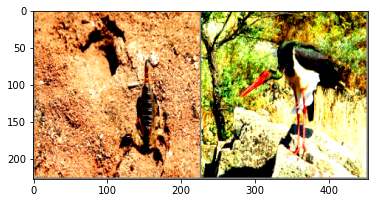

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Sketch# 1


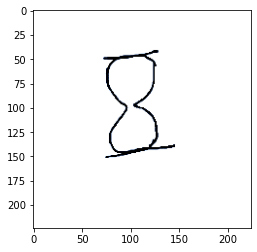

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual correct Image


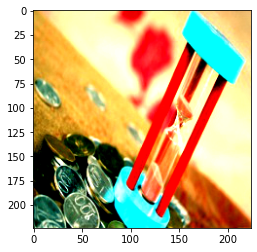

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Results for Sketch# 1


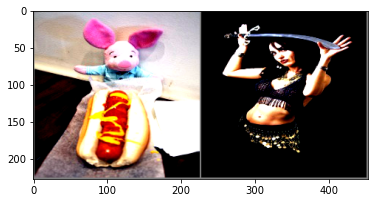

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Sketch# 2


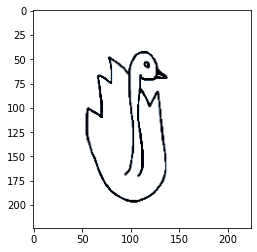

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual correct Image


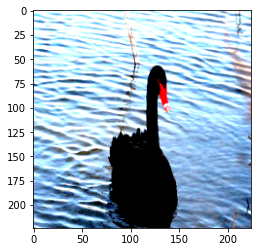

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Results for Sketch# 2


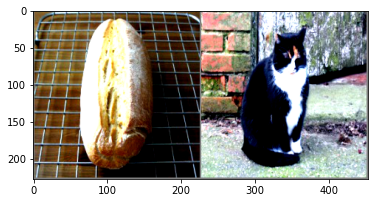

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Sketch# 3


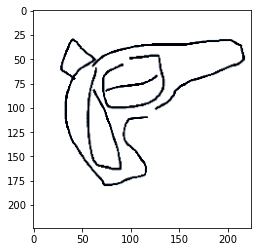

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual correct Image


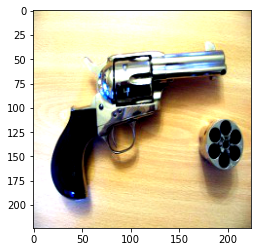

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Results for Sketch# 3


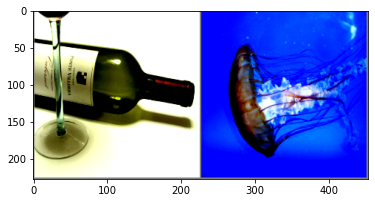

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input Sketch# 4


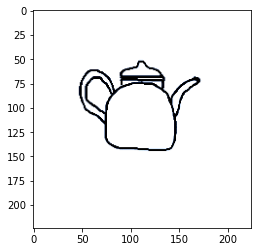

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual correct Image


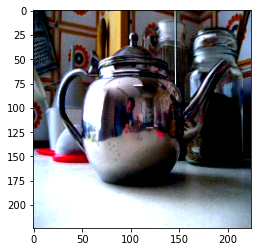

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Results for Sketch# 4


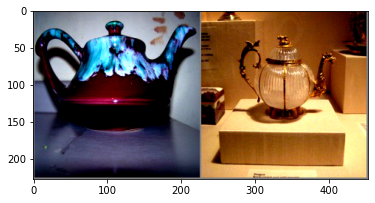

In [79]:
predict(val_loader,amount=5, top_k=2)

In [2]:
abspath_sketchy = os.path.abspath("sketchy_ckpt")
for counter,checkpoint in enumerate(os.listdir("./sketchy_ckpt"),1):
    checkpoint = os.path.join(abspath_sketchy,checkpoint)
    print(f"running checkpoint {counter}")
    print(checkpoint)
    run(checkpoint)
    print(f"finished running checkpoint {counter}")
    print("----------------------------------------")


running checkpoint 1
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': False, 'erase': False, 'rotation': False, 'hflip': False, 'vflip': False-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250
Skipping saving dict to pickle!
Loading pickle! retrieval_imgs_dicts/retrieval_imgs_dict_nfs_home_korzybskia_BA_sketchy_ckpt_Stylized=True,Transforms=-'jitter': False, 'erase': False, 'rotation': False, 'hflip': False, 'vflip': False-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.pickle
imgs db len
12500
12500
tensor([-5.2902e+01,  1.7236e+01,  6.5853e+00,  2.9784e+00,  5.2010e+00,
         1.0554e+01,  1.5178e+01,  1.0812e+01,  1.7253e+01,  5.7384e+01,
         1.5534e+01,  3.5207e+01, -2.3538e+01, -3.9464e+01,  6.2259e+00,
         5.0827e+01, -1.2528e+01, -6.3182e+00,  9.6776e+00,  2.7921e+01,
         1.3432e+01,  9.1386e+00, -1.5601e+01, -1.8052e+01,  8.7986e+00,
         1.2530e+01, -1.7966e+01,  1.8262e+01, -1.8194e+01, -1.9669e+01,
         3.0854e+01,  1.8958e+01,  1.1698e+01, -1.5139e+01, -2.0440e+00,
         2.6915e+01,  1.0437e+01,  3.5080e+01,  3.8901e+00,  1.5618e+01,
    

100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Top 2
Total hits_paths  4
Accuracy paths:  0.0032
Top 2
Total hits_labels  76
Accuracy paths:  0.0608
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


Top 4
Total hits_paths  8
Accuracy paths:  0.0064
Top 4
Total hits_labels  139
Accuracy paths:  0.1112
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


Top 6
Total hits_paths  9
Accuracy paths:  0.0072
Top 6
Total hits_labels  184
Accuracy paths:  0.1472
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


Top 8
Total hits_paths  13
Accuracy paths:  0.0104
Top 8
Total hits_labels  239
Accuracy paths:  0.1912
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


Top 10
Total hits_paths  17
Accuracy paths:  0.0136
Top 10
Total hits_labels  270
Accuracy paths:  0.216
finished running checkpoint 1
----------------------------------------
running checkpoint 2
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': False, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250
Skipping saving dict to pickle!
Loading pickle! retrieval_imgs_dicts/retrieval_imgs_dict_nfs_home_korzybskia_BA_sketchy_ckpt_Stylized=True,Transforms=-'jitter': False, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.pickle
imgs db len
12500
12500
tensor([ 1.3522e-01, -5.6017e+00,  1.1732e+00, -2.0919e+01,  1.0172e+01,
        -3.6537e+00,  6.8138e+00, -9.8952e+00, -3.0817e+00,  1.1735e+01,
         7.7929e+00,  4.3170e+00, -4.6570e+00,  6.3222e-01, -5.0452e+00,
         1.8523e+00, -5.5530e+00,  1.0349e+01, -7.8932e+00, -2.0327e-02,
         4.8768e+00, -3.0632e+00,  1.7586e-01, -1.5061e+01,  3.4701e+00,
        -2.6012e+00,  5.7908e+00,  3.8484e+00, -1.1505e+01,  1.2623e+01,
         4.9468e+00,  1.4697e+00,  1.0441e-01,  8.7025e-01,  7.0016e+00,
        -7.8418e+00, -4.1757e+00,  1.8896e+00,  9.1625e-01, -1.9246e-01,
       

100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


Top 2
Total hits_paths  41
Accuracy paths:  0.0328
Top 2
Total hits_labels  333
Accuracy paths:  0.2664
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


Top 4
Total hits_paths  73
Accuracy paths:  0.0584
Top 4
Total hits_labels  470
Accuracy paths:  0.376
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


Top 6
Total hits_paths  83
Accuracy paths:  0.0664
Top 6
Total hits_labels  551
Accuracy paths:  0.4408
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


Top 8
Total hits_paths  95
Accuracy paths:  0.076
Top 8
Total hits_labels  605
Accuracy paths:  0.484
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


Top 10
Total hits_paths  105
Accuracy paths:  0.084
Top 10
Total hits_labels  656
Accuracy paths:  0.5248
finished running checkpoint 2
----------------------------------------
running checkpoint 3
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': True, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=100.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250


100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


Writing dict to pickle...
Done writing pickle...
Returning imgs_db directly!
imgs db len
12500
12500
tensor([-4.2008e+00,  1.0745e+01,  5.0738e+00, -3.9266e+00, -1.7832e+00,
         2.9981e+00, -5.6726e+00,  7.4091e+00, -1.4687e+00,  1.6636e+00,
        -3.4488e+00,  3.0580e+00, -3.5972e+00,  3.0666e+00,  4.5589e+00,
        -8.4394e+00, -1.2384e+01,  4.2985e+00, -3.9752e+00,  5.6472e+00,
        -4.9865e-01,  1.2103e+01,  8.1920e+00,  1.2778e+01,  2.4164e+00,
        -8.7172e+00, -8.9405e+00, -7.5496e+00,  2.5284e+00,  3.5051e+00,
        -7.1912e+00,  9.7174e+00, -1.2356e+01, -5.9972e+00,  3.7706e+00,
         4.8937e+00,  9.1434e+00,  5.7754e+00,  9.4013e+00,  5.6951e-01,
        -4.0745e+00,  1.7265e+00, -6.5355e+00,  6.1584e+00,  4.0386e+00,
         6.5324e+00,  7.2757e+00, -3.5175e+00, -9.4138e+00,  6.0621e+00,
        -2.9034e+00, -7.9041e+00, -1.0945e+01, -3.7721e+00, -5.0821e+00,
        -1.2371e+01, -7.1874e+00,  1.2534e+00, -4.5454e+00,  2.8060e+00,
        -9.5121e+00, -1

100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Top 2
Total hits_paths  28
Accuracy paths:  0.0224
Top 2
Total hits_labels  223
Accuracy paths:  0.1784
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


Top 4
Total hits_paths  43
Accuracy paths:  0.0344
Top 4
Total hits_labels  342
Accuracy paths:  0.2736
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


Top 6
Total hits_paths  56
Accuracy paths:  0.0448
Top 6
Total hits_labels  411
Accuracy paths:  0.3288
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


Top 8
Total hits_paths  66
Accuracy paths:  0.0528
Top 8
Total hits_labels  475
Accuracy paths:  0.38
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


Top 10
Total hits_paths  81
Accuracy paths:  0.0648
Top 10
Total hits_labels  529
Accuracy paths:  0.4232
finished running checkpoint 3
----------------------------------------
running checkpoint 4
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': True, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=50.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250


100%|██████████| 20/20 [00:02<00:00,  7.02it/s]


Writing dict to pickle...
Done writing pickle...
Returning imgs_db directly!
imgs db len
12500
12500
tensor([  4.8386,  18.4318,  -4.6432,  -5.9984, -11.0389,  -0.4986, -21.7299,
         12.9735,  12.8236, -27.0874,  -2.9503,  -6.2066, -19.2281,  17.8059,
          6.9249, -17.8050, -13.3292,  -9.4113,  -3.7589,  19.4853,  -8.6408,
         32.7741,  31.6803,  13.1542,  -5.9380, -19.5210, -23.4186, -15.5233,
         -0.9717,  -5.4385, -14.8727,  -8.4316, -40.8399,  -0.6875,  -5.9786,
          2.5294,   0.1190,  -5.2275,  24.5203,  -0.1867, -33.9710,  30.8897,
          7.8500,   7.1802, -16.2582,   2.3687,  17.6870,  -9.7037, -11.7370,
        -23.6556,   2.9285, -14.8397,  17.5567, -24.4682,  10.2992, -23.1495,
         -1.7821,   9.9411,  -4.4884,  -0.5475, -12.3091,   6.3193,  -6.5881,
          4.3769, -41.9518,  16.0722,  31.9380,   7.8813, -29.3745, -27.0658,
        -14.8891, -12.7984,  -1.5224,  46.7406, -45.9826,  35.6639, -17.1364,
         38.7800,  -3.7146, -35.7162, -14

100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Top 2
Total hits_paths  6
Accuracy paths:  0.0048
Top 2
Total hits_labels  97
Accuracy paths:  0.0776
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


Top 4
Total hits_paths  12
Accuracy paths:  0.0096
Top 4
Total hits_labels  172
Accuracy paths:  0.1376
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


Top 6
Total hits_paths  15
Accuracy paths:  0.012
Top 6
Total hits_labels  222
Accuracy paths:  0.1776
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


Top 8
Total hits_paths  20
Accuracy paths:  0.016
Top 8
Total hits_labels  278
Accuracy paths:  0.2224
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


Top 10
Total hits_paths  23
Accuracy paths:  0.0184
Top 10
Total hits_labels  319
Accuracy paths:  0.2552
finished running checkpoint 4
----------------------------------------
running checkpoint 5
/nfs/home/korzybskia/BA/sketchy_ckpt/Transforms=-'jitter': True, 'erase': False, 'rotation': False, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250
Skipping saving dict to pickle!
Loading pickle! retrieval_imgs_dicts/retrieval_imgs_dict_nfs_home_korzybskia_BA_sketchy_ckpt_Transforms=-'jitter': True, 'erase': False, 'rotation': False, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.pickle
imgs db len
12500
12500
tensor([-1.6328e+00,  2.5335e+00, -4.3920e+00, -1.7856e+01,  7.2855e+00,
        -1.2653e+00, -7.1999e+00,  1.5842e+00, -4.6872e+00,  4.0478e+00,
         4.3354e+00, -1.0741e+01,  1.4935e+00,  9.1742e+00,  5.2307e+00,
        -6.1397e+00,  3.9877e+00, -3.4247e+00, -2.3614e-01,  1.7063e+00,
         3.9623e+00,  2.4997e+00, -3.8601e+00, -1.4270e+00,  6.5957e-02,
         3.1047e+00,  1.1659e+00,  2.9269e+00,  7.4705e+00,  5.1701e+00,
         1.4877e+00, -2.4350e+00, -2.3050e+00,  1.3273e+00, -6.0158e+00,
         3.6601e+00,  1.3605e+00,  1.8080e+00, -4.4065e+00,  9.9024e-01,
        -7.7073e+00, 

100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Top 2
Total hits_paths  30
Accuracy paths:  0.024
Top 2
Total hits_labels  391
Accuracy paths:  0.3128
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


Top 4
Total hits_paths  52
Accuracy paths:  0.0416
Top 4
Total hits_labels  544
Accuracy paths:  0.4352
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


Top 6
Total hits_paths  69
Accuracy paths:  0.0552
Top 6
Total hits_labels  625
Accuracy paths:  0.5
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]


Top 8
Total hits_paths  85
Accuracy paths:  0.068
Top 8
Total hits_labels  685
Accuracy paths:  0.548
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


Top 10
Total hits_paths  103
Accuracy paths:  0.0824
Top 10
Total hits_labels  747
Accuracy paths:  0.5976
finished running checkpoint 5
----------------------------------------
running checkpoint 6
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': False, 'erase': False, 'rotation': False, 'hflip': False, 'vflip': False-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=150.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250


100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


Writing dict to pickle...
Done writing pickle...
Returning imgs_db directly!
imgs db len
12500
12500
tensor([-7.0154e+01, -3.6553e+00, -3.6494e+00,  6.5982e+00,  6.0477e+00,
        -2.8064e+00,  4.3223e+01,  3.0912e+01, -3.7208e+00,  2.5309e+01,
         8.6715e+00,  2.3653e+01, -4.3872e+01, -9.6368e+00,  4.9607e+00,
         5.8050e+01,  1.7953e+01,  3.0269e+01,  1.8859e+01,  1.2070e+01,
         1.3182e+00,  1.2152e+01, -3.2548e+01,  1.8072e+01,  3.1537e+01,
        -1.0788e+01, -1.5072e+00,  2.9385e+01, -6.8157e+00, -2.2827e+01,
         2.8730e+01,  3.7667e+01,  4.9993e+00, -7.0479e-01, -6.3815e+00,
         4.6129e+01,  1.8451e+01,  5.6954e+01,  2.9190e+01,  1.3361e+01,
         5.2702e+00,  1.2603e+01,  1.2974e+01, -2.4782e+01,  4.4598e+01,
         6.6878e+00, -2.8890e-01, -3.1049e+01, -2.1946e+01, -4.6380e+01,
        -9.8956e+00, -1.8695e+01,  4.6180e+01, -1.8705e+00, -1.3595e+01,
         1.7837e+01,  5.1562e+00,  4.0201e+01,  5.7369e+00,  5.7608e+00,
        -3.2430e+00,  1

100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Top 2
Total hits_paths  1
Accuracy paths:  0.0008
Top 2
Total hits_labels  79
Accuracy paths:  0.0632
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


Top 4
Total hits_paths  8
Accuracy paths:  0.0064
Top 4
Total hits_labels  146
Accuracy paths:  0.1168
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


Top 6
Total hits_paths  11
Accuracy paths:  0.0088
Top 6
Total hits_labels  199
Accuracy paths:  0.1592
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


Top 8
Total hits_paths  12
Accuracy paths:  0.0096
Top 8
Total hits_labels  241
Accuracy paths:  0.1928
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


Top 10
Total hits_paths  13
Accuracy paths:  0.0104
Top 10
Total hits_labels  285
Accuracy paths:  0.228
finished running checkpoint 6
----------------------------------------
running checkpoint 7
/nfs/home/korzybskia/BA/sketchy_ckpt/Transforms=-'jitter': True, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250
Skipping saving dict to pickle!
Loading pickle! retrieval_imgs_dicts/retrieval_imgs_dict_nfs_home_korzybskia_BA_sketchy_ckpt_Transforms=-'jitter': True, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.pickle
imgs db len
12500
12500
tensor([  9.0427,  -9.8342,   5.4099,   8.6072,   5.2750,   9.5750,   5.0860,
         -0.1313,  -3.7912,  -1.5952,  -2.4313,   6.2820,  -4.2167,   1.4164,
         -6.7100,  -7.2677,   7.7089,  -5.8738,  -0.8120,  -4.5936,  -4.0133,
         10.5729,  -4.4551,   5.0599,   5.1505,  -5.8921,  -8.8403,  -0.5774,
         -5.7735,  -2.8550,   3.9560,   8.5450,  -1.2051,  -4.6983,  -5.1432,
          4.1272,   5.4331,   3.7015,   5.5044,   4.3153,  -3.1318,  -8.3769,
         -0.4036,   9.0893,   5.9682,  -2.6451,   7.0179,  -0.2846,   3.4058,
          4.4417,  -1.3372,   3.4488,   7.0540,   1.2510,   

100%|██████████| 20/20 [00:03<00:00,  5.10it/s]


Top 2
Total hits_paths  40
Accuracy paths:  0.032
Top 2
Total hits_labels  394
Accuracy paths:  0.3152
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.80it/s]


Top 4
Total hits_paths  67
Accuracy paths:  0.0536
Top 4
Total hits_labels  538
Accuracy paths:  0.4304
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


Top 6
Total hits_paths  84
Accuracy paths:  0.0672
Top 6
Total hits_labels  624
Accuracy paths:  0.4992
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


Top 8
Total hits_paths  99
Accuracy paths:  0.0792
Top 8
Total hits_labels  688
Accuracy paths:  0.5504
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Top 10
Total hits_paths  115
Accuracy paths:  0.092
Top 10
Total hits_labels  740
Accuracy paths:  0.592
finished running checkpoint 7
----------------------------------------
running checkpoint 8
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': False, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=150.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250


100%|██████████| 20/20 [00:02<00:00,  6.80it/s]


Writing dict to pickle...
Done writing pickle...
Returning imgs_db directly!
imgs db len
12500
12500
tensor([ -1.9080,   3.0623,  -2.8811,  13.2314,  -3.0933,   0.3011,  -1.3144,
         -0.7132,  19.0912,  -0.8313,   0.8956,   3.7590,  -5.1599,  -7.1388,
         -5.8883,   0.5208,  -1.5935,  -5.2751,  -1.3835,  18.5433,  -7.2319,
          5.6757,  -6.1317,  -7.1795,  -6.8753,  12.6831,  -3.3808, -11.6047,
         -2.2769,  -4.1285,  -3.5379, -12.1317, -13.1981,   6.8765,   9.5362,
         -8.9479,   6.9364, -10.1748,   3.5915,  -6.9341,  -1.1740,   2.6193,
          6.6103,   8.4196,   3.3112, -15.2768,  13.4600,  -2.1238,   5.1417,
        -16.7097, -12.4717,   2.7562,   5.1076,   0.3853, -14.4795,   1.2581,
         -4.5176,  -9.1490,   1.7389,  13.1217,  11.0299,   2.1528,  14.6794,
         -0.8162,   8.9138,  17.3277,   1.7445,  -8.8961,  -3.7401,  -7.7787,
         28.0948, -20.1700,  -5.2208,  11.2942,   0.8967,   2.5863,   3.1082,
         -1.7853,  -8.3497,   2.6042,  18

100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


Top 2
Total hits_paths  46
Accuracy paths:  0.0368
Top 2
Total hits_labels  304
Accuracy paths:  0.2432
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


Top 4
Total hits_paths  61
Accuracy paths:  0.0488
Top 4
Total hits_labels  429
Accuracy paths:  0.3432
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


Top 6
Total hits_paths  78
Accuracy paths:  0.0624
Top 6
Total hits_labels  527
Accuracy paths:  0.4216
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:03<00:00,  5.29it/s]


Top 8
Total hits_paths  91
Accuracy paths:  0.0728
Top 8
Total hits_labels  596
Accuracy paths:  0.4768
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


Top 10
Total hits_paths  105
Accuracy paths:  0.084
Top 10
Total hits_labels  656
Accuracy paths:  0.5248
finished running checkpoint 8
----------------------------------------
running checkpoint 9
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': False, 'erase': False, 'rotation': False, 'hflip': False, 'vflip': False-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=50.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


Writing dict to pickle...
Done writing pickle...
Returning imgs_db directly!
imgs db len
12500
12500
tensor([-50.1223,  -5.7607,  18.8372,  15.2952,   3.7305, -13.8802,  52.7240,
         28.3503,  -8.7225,  20.1573, -20.9540,   5.9861, -37.1123,  -2.6097,
         -7.7564,  38.6076,  36.3243,  17.8808,  24.7564,   4.6846,   0.2212,
        -10.0474, -13.0859,  26.6729,  10.3401, -12.7845, -17.2031,  -5.7271,
         -1.4917,  13.9652,  -8.7218,   7.6359, -21.0543,   7.8322, -10.8291,
          5.3004,  18.8785,  44.9362,  45.0373, -10.2516,   5.0180,  29.2080,
        -11.0679, -26.6121,  17.2266, -14.3953,   0.9827,  -4.7050,   6.7314,
        -55.0475,  30.7928,   4.8866,  37.3884,  20.1482, -10.1709,  18.3683,
         -3.0712,  21.9911,  -7.0169,  13.9097,   4.0575,  40.1387,  18.8862,
          0.3321,  -2.0686,   7.2182, -42.4542,   6.1795,  17.4718,  -1.4970,
        -33.7644, -10.0798, -23.3738,  -6.0918,   9.9449,   9.2996,  -7.6569,
          4.9394,  38.3997,  -4.5359,   2

100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


Top 2
Total hits_paths  1
Accuracy paths:  0.0008
Top 2
Total hits_labels  91
Accuracy paths:  0.0728
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


Top 4
Total hits_paths  4
Accuracy paths:  0.0032
Top 4
Total hits_labels  155
Accuracy paths:  0.124
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


Top 6
Total hits_paths  5
Accuracy paths:  0.004
Top 6
Total hits_labels  203
Accuracy paths:  0.1624
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.76it/s]


Top 8
Total hits_paths  5
Accuracy paths:  0.004
Top 8
Total hits_labels  242
Accuracy paths:  0.1936
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Top 10
Total hits_paths  7
Accuracy paths:  0.0056
Top 10
Total hits_labels  282
Accuracy paths:  0.2256
finished running checkpoint 9
----------------------------------------
running checkpoint 10
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': True, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=150.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250


100%|██████████| 20/20 [00:03<00:00,  6.52it/s]


Writing dict to pickle...
Done writing pickle...
Returning imgs_db directly!
imgs db len
12500
12500
tensor([-7.4740e+00,  2.1153e+01,  2.6541e+00,  3.2139e+00, -4.7896e+00,
         1.4613e+01, -8.3275e+00,  3.6763e+00,  2.7297e+00,  7.3818e+00,
        -8.7416e+00,  2.5467e+00, -6.4640e+00, -1.6310e-01,  1.1051e+01,
        -1.9793e+01, -1.9195e+01, -4.3702e+00, -9.8122e+00,  3.1299e+00,
        -1.2034e+01,  1.7013e+01, -3.8559e+00,  1.2569e+01,  1.2725e+00,
        -1.2839e+01, -3.5588e+01, -2.0937e+01,  8.5449e+00, -6.8602e-01,
        -7.0202e+00,  6.9972e+00, -3.3330e+01, -1.4061e+01, -7.2432e-01,
        -5.8163e+00, -1.3051e+01, -1.2956e+01,  2.0700e+01, -1.5106e+01,
        -9.6789e-03,  2.1239e+00, -9.6497e+00,  6.0126e-01, -2.8802e+00,
         1.9421e+01,  1.1063e+01, -9.1893e+00, -1.6502e+01,  1.0809e+01,
        -1.1047e+00, -2.8731e+01, -1.6153e+01, -7.2966e+00,  4.0534e+00,
        -3.2382e+01,  4.6426e+00,  2.0761e+01, -1.9821e+01,  6.7095e+00,
        -1.8345e+01, -2

100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


Top 2
Total hits_paths  20
Accuracy paths:  0.016
Top 2
Total hits_labels  235
Accuracy paths:  0.188
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


Top 4
Total hits_paths  36
Accuracy paths:  0.0288
Top 4
Total hits_labels  331
Accuracy paths:  0.2648
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


Top 6
Total hits_paths  49
Accuracy paths:  0.0392
Top 6
Total hits_labels  414
Accuracy paths:  0.3312
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Top 8
Total hits_paths  58
Accuracy paths:  0.0464
Top 8
Total hits_labels  477
Accuracy paths:  0.3816
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.62it/s]


Top 10
Total hits_paths  69
Accuracy paths:  0.0552
Top 10
Total hits_labels  541
Accuracy paths:  0.4328
finished running checkpoint 10
----------------------------------------
running checkpoint 11
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': False, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=50.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250


100%|██████████| 20/20 [00:02<00:00,  6.67it/s]


Writing dict to pickle...
Done writing pickle...
Returning imgs_db directly!
imgs db len
12500
12500
tensor([ 5.9192e+00, -1.0139e+01,  1.0446e+01,  1.0558e+01,  6.9907e+00,
         6.8780e+00, -1.1305e+00,  6.0095e-01,  1.0412e+01,  1.0695e+01,
         3.3983e+00,  7.1455e+00, -1.0055e+00,  1.3722e+00, -4.0636e-01,
         6.4337e+00, -3.2004e+00,  3.2034e+00, -1.2650e+01, -6.8346e-02,
        -1.0029e+00,  2.8488e+00, -3.6000e-01, -1.0730e+01,  5.0735e+00,
         9.3493e+00, -3.1152e+00,  4.3448e+00, -5.5364e+00,  2.8320e+00,
        -2.6907e+00, -1.2324e+01, -5.3782e+00,  4.2692e+00,  4.6640e+00,
        -1.0089e+01, -5.7729e+00,  2.4544e+00, -4.6010e+00, -1.0689e+01,
        -5.6619e+00,  5.5248e+00, -5.5120e+00, -2.5112e+00,  1.9039e+00,
        -7.3022e+00,  5.4116e+00, -2.1621e+00, -4.5376e+00, -5.7503e+00,
        -4.7987e+00, -2.8343e+00, -8.7590e+00,  2.6640e+00,  2.0414e+00,
        -7.1340e-01, -4.2284e+00,  3.0301e+00,  7.3780e+00,  9.6313e+00,
         9.7261e+00, -4

100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


Top 2
Total hits_paths  22
Accuracy paths:  0.0176
Top 2
Total hits_labels  280
Accuracy paths:  0.224
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.52it/s]


Top 4
Total hits_paths  40
Accuracy paths:  0.032
Top 4
Total hits_labels  406
Accuracy paths:  0.3248
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


Top 6
Total hits_paths  47
Accuracy paths:  0.0376
Top 6
Total hits_labels  480
Accuracy paths:  0.384
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.76it/s]


Top 8
Total hits_paths  63
Accuracy paths:  0.0504
Top 8
Total hits_labels  543
Accuracy paths:  0.4344
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


Top 10
Total hits_paths  74
Accuracy paths:  0.0592
Top 10
Total hits_labels  596
Accuracy paths:  0.4768
finished running checkpoint 11
----------------------------------------
running checkpoint 12
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': True, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250
Skipping saving dict to pickle!
Loading pickle! retrieval_imgs_dicts/retrieval_imgs_dict_nfs_home_korzybskia_BA_sketchy_ckpt_Stylized=True,Transforms=-'jitter': True, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.pickle
imgs db len
12500
12500
tensor([  0.7920,   2.8209,  -6.3999,   4.1946,  -4.2969,   0.8581,  -4.0494,
          5.5499,   6.7564,  -2.2346,   1.6081,  -2.8613,  -1.2588,   8.1438,
          9.2669,  -9.5967,  -0.1006,   2.8691,  -8.1345,   3.7109,   0.7852,
         10.1798,   8.1353,   7.4906,   9.4102,  -6.0922,  -7.7948,  -4.0496,
          1.0884,   7.5174,  -6.4974,   2.1069, -11.1307,   0.8508,  -2.3238,
          7.0046,   7.5690,  -1.2602,   2.1448,  -2.6053,   0.2829,   5.1437,
         -2.6381,  -3.1133,   0.9203,   0.5064,   7.2828,  -2.6490,  -9.3615,
         -1.0008,   1.6568,  -4.8393,  -4.2874

100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


Top 2
Total hits_paths  18
Accuracy paths:  0.0144
Top 2
Total hits_labels  233
Accuracy paths:  0.1864
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


Top 4
Total hits_paths  33
Accuracy paths:  0.0264
Top 4
Total hits_labels  340
Accuracy paths:  0.272
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


Top 6
Total hits_paths  49
Accuracy paths:  0.0392
Top 6
Total hits_labels  423
Accuracy paths:  0.3384
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


Top 8
Total hits_paths  62
Accuracy paths:  0.0496
Top 8
Total hits_labels  488
Accuracy paths:  0.3904
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


Top 10
Total hits_paths  70
Accuracy paths:  0.056
Top 10
Total hits_labels  540
Accuracy paths:  0.432
finished running checkpoint 12
----------------------------------------
running checkpoint 13
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': False, 'erase': False, 'rotation': True, 'hflip': True, 'vflip': True-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=100.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250


100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


Writing dict to pickle...
Done writing pickle...
Returning imgs_db directly!
imgs db len
12500
12500
tensor([-3.2977e+00, -2.8427e+00, -4.0909e+00,  4.0229e+00,  5.4110e+00,
         1.1686e+00, -5.2860e+00,  3.8095e+00,  1.5185e+01,  4.1786e+00,
         6.4155e+00,  3.7608e+00, -6.7425e+00,  4.1081e+00, -1.5429e+00,
         9.1960e+00, -6.6292e+00,  8.8372e+00, -3.9552e+00,  1.9984e+00,
        -1.7797e+00,  5.0762e+00, -4.2809e+00, -1.4799e+01, -5.9061e+00,
         1.2568e+01, -1.4395e+00,  4.9800e+00, -1.0163e+01,  3.4097e+00,
         2.1447e-02, -1.4489e+01,  3.9163e-01,  1.7773e+00,  8.4864e+00,
        -9.8173e+00, -6.2214e+00,  1.7338e+00, -7.5457e+00, -1.0048e+01,
         4.5404e-01,  1.0335e+01, -7.1275e+00,  9.2580e+00, -3.6916e-01,
        -1.3382e+01,  7.8975e+00, -2.8114e+00, -8.4717e+00, -4.4318e-03,
        -6.8059e+00, -4.0429e+00, -1.0019e+01, -4.0830e+00,  5.7795e+00,
        -5.1806e+00, -3.5676e+00, -8.6694e+00,  2.8468e+00,  1.2304e+01,
         8.7558e+00, -3

100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


Top 2
Total hits_paths  21
Accuracy paths:  0.0168
Top 2
Total hits_labels  297
Accuracy paths:  0.2376
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


Top 4
Total hits_paths  40
Accuracy paths:  0.032
Top 4
Total hits_labels  427
Accuracy paths:  0.3416
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Top 6
Total hits_paths  57
Accuracy paths:  0.0456
Top 6
Total hits_labels  516
Accuracy paths:  0.4128
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


Top 8
Total hits_paths  72
Accuracy paths:  0.0576
Top 8
Total hits_labels  578
Accuracy paths:  0.4624
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


Top 10
Total hits_paths  89
Accuracy paths:  0.0712
Top 10
Total hits_labels  623
Accuracy paths:  0.4984
finished running checkpoint 13
----------------------------------------
running checkpoint 14
/nfs/home/korzybskia/BA/sketchy_ckpt/Stylized=True,Transforms=-'jitter': False, 'erase': False, 'rotation': False, 'hflip': False, 'vflip': False-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=100.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250


100%|██████████| 20/20 [00:02<00:00,  7.15it/s]


Writing dict to pickle...
Done writing pickle...
Returning imgs_db directly!
imgs db len
12500
12500
tensor([-6.1100e+01,  1.2517e+01, -7.8934e+00, -2.6339e+00, -3.4315e+00,
         1.5166e+01, -3.7686e+00,  6.5097e+00,  5.2888e+00,  3.8403e+01,
         2.1713e+00,  1.1868e+01, -2.6912e+01, -3.7634e+01,  1.5199e-01,
         5.7622e+01, -1.5379e+01,  3.9032e+01, -9.8128e-01,  2.1442e+01,
        -1.2073e+01, -1.5576e+00, -8.7375e+00, -2.4395e+01,  6.3074e+00,
         6.7717e+00,  9.4774e+00, -5.0568e+00, -4.6693e+00,  1.0269e+01,
         1.4801e+01,  1.6980e+01, -1.6773e+00, -2.2671e+00, -6.5461e+00,
         2.0427e+00,  3.3000e+00,  4.5646e+01,  1.5563e+00,  4.1634e+00,
         1.9099e+01,  2.0123e+01,  3.5881e+00, -1.0568e+01,  1.9825e+00,
        -8.0714e-01,  5.2237e+01, -1.1543e+01, -2.3261e+01,  1.1737e+01,
        -6.2313e+00, -1.2043e+01,  1.9972e+01,  6.3022e+00, -7.3870e+00,
         4.1019e+01, -1.3704e+01,  2.3867e+00,  1.6782e+01, -4.8693e+00,
        -1.2407e+01, -4

100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


Top 2
Total hits_paths  3
Accuracy paths:  0.0024
Top 2
Total hits_labels  52
Accuracy paths:  0.0416
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


Top 4
Total hits_paths  5
Accuracy paths:  0.004
Top 4
Total hits_labels  98
Accuracy paths:  0.0784
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.60it/s]


Top 6
Total hits_paths  6
Accuracy paths:  0.0048
Top 6
Total hits_labels  138
Accuracy paths:  0.1104
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


Top 8
Total hits_paths  8
Accuracy paths:  0.0064
Top 8
Total hits_labels  177
Accuracy paths:  0.1416
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


Top 10
Total hits_paths  9
Accuracy paths:  0.0072
Top 10
Total hits_labels  214
Accuracy paths:  0.1712
finished running checkpoint 14
----------------------------------------
running checkpoint 15
/nfs/home/korzybskia/BA/sketchy_ckpt/Transforms=-'jitter': False, 'erase': False, 'rotation': False, 'hflip': False, 'vflip': False-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.ckpt


/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nfs/home/korzybskia/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


photo
IMGS DIR
./Data/Sketchy/256x256/photo
SKETCHES DIR
./Data/Sketchy/256x256/sketch
11250
Skipping saving dict to pickle!
Loading pickle! retrieval_imgs_dicts/retrieval_imgs_dict_nfs_home_korzybskia_BA_sketchy_ckpt_Transforms=-'jitter': False, 'erase': False, 'rotation': False, 'hflip': False, 'vflip': False-,Batchsize=64,LR=0.001,FEATURE_VEC_SIZE=256,epoch=199.pickle
imgs db len
12500
12500
tensor([-15.3112,   4.9954, -31.9170,   8.3694,   4.5518, -36.8470, -19.6118,
          6.0219, -16.1176,  32.2929,  20.6085,  12.4124,  -3.7342, -19.1836,
          1.8777, -17.3389,   4.2201,  16.5311,   8.0920,   3.5285,  -0.5928,
         -4.5603,  11.8519,  15.8322,  -1.9407,   4.0525,  -5.8282, -11.5945,
         39.0421, -17.8534,  13.0215, -20.5614,   3.2044,   4.2847,  21.0017,
         31.5478,  -4.8382,  -8.1971,  -8.8979,  14.9245,  -7.2376,  -4.3095,
          7.7937,   9.9234, -14.6926,  12.0816,  -1.0333,   7.4561,  -3.8680,
         36.4419,  11.2582, -13.6441, -12.2617, -24.1330

100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Top 2
Total hits_paths  10
Accuracy paths:  0.008
Top 2
Total hits_labels  302
Accuracy paths:  0.2416
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


Top 4
Total hits_paths  27
Accuracy paths:  0.0216
Top 4
Total hits_labels  438
Accuracy paths:  0.3504
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


Top 6
Total hits_paths  40
Accuracy paths:  0.032
Top 6
Total hits_labels  533
Accuracy paths:  0.4264
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


Top 8
Total hits_paths  54
Accuracy paths:  0.0432
Top 8
Total hits_labels  602
Accuracy paths:  0.4816
Starting calc_model_accuracy_with_paths_and_labels


100%|██████████| 20/20 [00:03<00:00,  5.36it/s]

Top 10
Total hits_paths  68
Accuracy paths:  0.0544
Top 10
Total hits_labels  652
Accuracy paths:  0.5216
finished running checkpoint 15
----------------------------------------
